In [ ]:
#imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Optional settings
sns.set(style='whitegrid')
pd.set_option('display.max_columns', None)


In [ ]:
#loading the dataset
df = pd.read_excel("../data/online_retail.xlsx")
df.head()


In [ ]:
#shape and columns
df.shape
df.columns


In [ ]:
#info and description
df.info()
df.describe()

In [ ]:
#drop missing customer IDs
df = df.dropna(subset=['CustomerID'])
print("After dropping missing CustomerIDs:", df.shape)

In [ ]:
#remove canceled orders
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]
print("After removing canceled transactions:", df.shape)


In [ ]:
#remove negative quantities
df = df[df['Quantity'] > 0]
print("After removing negative quantities:", df.shape)

In [ ]:
#remove invalid unit prices
df = df[df['UnitPrice'] > 0]
print("After removing invalid unit prices:", df.shape)

In [ ]:
#drop duplicate rows
df = df.drop_duplicates()
print("After dropping duplicates:", df.shape)

In [ ]:
#feature engineering - total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df[['Quantity', 'UnitPrice', 'TotalPrice']].head()

In [ ]:
#feature engineering - invoice month 
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) #incase data not paresed
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df[['InvoiceDate', 'InvoiceMonth']].head()

In [ ]:
#convert customer ID to string
df['CustomerID'] = df['CustomerID'].astype(str)

In [ ]:
#save the cleaned dataset
print("Saving cleaned dataset...")
df.to_csv('../data/online_retail_cleaned.csv', index=False)


In [ ]:
#final check 
print("✅ Cleaned dataset shape:", df.shape)
print("🧍 Unique customers:", df['CustomerID'].nunique())
print("📅 Date range:", df['InvoiceDate'].min(), "to", df['InvoiceDate'].max())
# --- IGNORE ---

In [ ]:
#revenue by month
monthly_revenue = df.groupby('InvoiceMonth')['TotalPrice'].sum().reset_index()
#convert period to string
monthly_revenue['InvoiceMonth'] = monthly_revenue['InvoiceMonth'].astype(str)

plt.figure(figsize=(12, 6))
sns.lineplot(x='InvoiceMonth', y='TotalPrice', data=monthly_revenue, marker='o')
plt.title('Monthly Revenue')
plt.xlabel('Invoice Month')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
#top products by revenue
top_products = df.groupby('Description')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalPrice', y='Description', data=top_products, palette='viridis')
plt.title('Top 10 Products by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

In [ ]:
#top 10 products by quantity sold
top_products_quantity = df.groupby('Description')['Quantity'].sum().reset_index().sort_values(by='Quantity', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='Quantity', y='Description', data=top_products_quantity, palette='magma')
plt.title('Top 10 Products by Quantity Sold')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.tight_layout()
plt.show()

In [ ]:
#revenue by country
country_revenue = df.groupby('Country')['TotalPrice'].sum().reset_index().sort_values(by='TotalPrice', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='TotalPrice', y='Country', data=country_revenue, palette='coolwarm')
plt.title('Top 10 Countries by Revenue')
plt.xlabel('Total Revenue')
plt.ylabel('Country')
plt.tight_layout()
plt.show()

In [ ]:
# Revenue per customer
customer_revenue = df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False)

# Quartiles (Q1, Median, Q3)
quartiles = customer_revenue.quantile([0.25, 0.5, 0.75])
print("Customer Revenue Quartiles:\n", quartiles)

# Calculate 80th percentile (top 20% cutoff)
top_20_cutoff = customer_revenue.quantile(0.80)

# Total revenue from top 20% customers
top_20_revenue = customer_revenue[customer_revenue >= top_20_cutoff].sum()
total_revenue = customer_revenue.sum()

# Print result
print("Top 20% of customers contributed {:.2f}% of revenue".format(100 * top_20_revenue / total_revenue))


In [25]:
''' 
We are creating a rfm snapshot date to analyze 
customer behavior up to a specific point in time.

recency = the time since the last purchase (lower is better)
frequency = the number of purchases (higher is better)
monetary = the total revenue (higher is better)

'''
# define snapshot date (day after the last invoice date)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Snapshot date:", snapshot_date)

# calculate RFM metrics
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # recency
    'InvoiceNo': 'count',  # frequency
    'TotalPrice': 'sum'  # monetary
})

# rename columns
rfm_df = rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

# reset index
rfm_df = rfm_df.reset_index()

#quick look
print(rfm_df.head())
print(rfm_df.describe())



Snapshot date: 2011-12-10 12:50:00
  CustomerID  Recency  Frequency  Monetary
0    12346.0      326          1  77183.60
1    12347.0        2        182   4310.00
2    12348.0       75         31   1797.24
3    12349.0       19         73   1757.55
4    12350.0      310         17    334.40
           Recency    Frequency       Monetary
count  4338.000000  4338.000000    4338.000000
mean     92.536422    90.523744    2048.688081
std     100.014169   225.506968    8985.230220
min       1.000000     1.000000       3.750000
25%      18.000000    17.000000     306.482500
50%      51.000000    41.000000     668.570000
75%     142.000000    98.000000    1660.597500
max     374.000000  7676.000000  280206.020000


  R_score F_score M_score RFM_Segment            Segment
0       1       1       4         114       Big Spenders
1       4       4       4         444     Best Customers
2       2       2       4         224       Big Spenders
3       3       3       4         334       Big Spenders
4       1       1       2         112  At Risk Customers


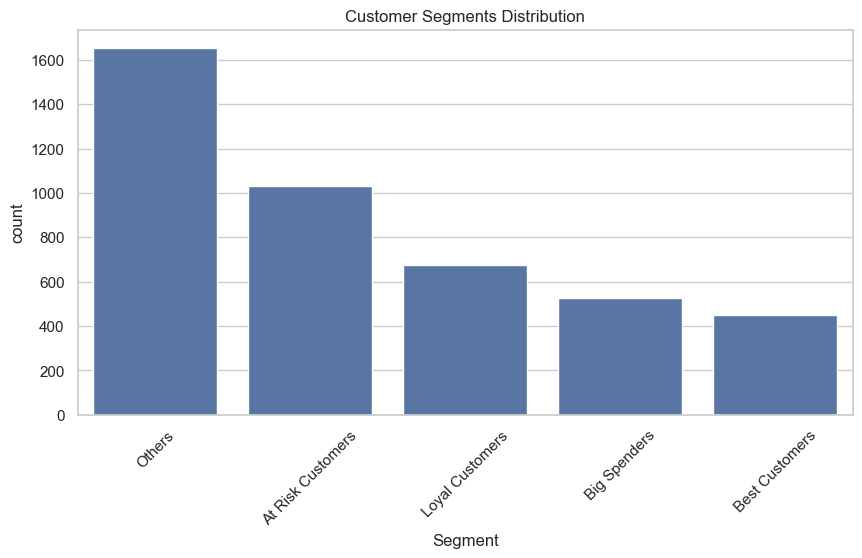

In [29]:
'''
RFM table has been created now we will focus on scoring 
each customer and segmenting then based on RFM quartiles
'''

#assign quartiles to RFM metrics
rfm_df['R_score'] = pd.qcut(rfm_df['Recency'], 4, labels=[4, 3, 2, 1])  # lower recency = higher score
rfm_df['F_score'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])  # higher frequency = higher score
rfm_df['M_score'] = pd.qcut(rfm_df['Monetary'], 4, labels=[1, 2, 3, 4])  # higher monetary = higher score 

#combine into RFM segments 
rfm_df['RFM_Segment'] = rfm_df['R_score'].astype(str) + rfm_df['F_score'].astype(str) + rfm_df['M_score'].astype(str)

#map to named segments 
def segment_map(segment):
    if segment == '444':
        return 'Best Customers'
    elif segment.startswith('4'):
        return 'Loyal Customers'
    elif segment.endswith('4'):
        return 'Big Spenders'
    elif segment.startswith('1'):
        return 'At Risk Customers'
    else:
        return 'Others'
    
rfm_df['Segment'] = rfm_df['RFM_Segment'].apply(segment_map)

#quick look at segments
print(rfm_df[['R_score', 'F_score', 'M_score', 'RFM_Segment', 'Segment']].head())

#visualize segment distribution

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
sns.countplot(data=rfm_df, x='Segment', order=rfm_df['Segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Customer Segments Distribution')
plt.show()

import os

# Create 'outputs' directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)

#save RFM table
rfm.to_csv('outputs/rfm_segments_customers.csv', index=False)



In [ ]:
#normalize RFM scores for visualization

from sklearn.preprocessing import StandardScaler

#SELECT RFM columns
rfm_scores = rfm_df[['Recency', 'Frequency', 'Monetary']]

# Scale the RFM scores
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_scores)

#find optimal number of clusters using the Elbow Method
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Test different cluster counts
sse = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    sse.append(model.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8,5))
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()



In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Standardize the RFM data (important for KMeans)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

# 2. Use Elbow Method to find optimal number of clusters 
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# 4. Apply KMeans with chosen number of clusters (say k=4 based on elbow plot)
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)